# Gatys Implementation of Neural Style Transfer

## Imports

In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import models, transforms
import torch.optim.lr_scheduler as lr_scheduler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### Parameters

In [2]:
#Parameters to update

name_content = "jardin_japonego"
name_style = "garouste - gerard-garouste_1946/garouste_2"

In [3]:
content_url = "images_test/"+name_content+".jpg"
style_url = "bd-peintres/"+name_style+".jpg"

#gerard-garouste_1946/garouste_2.jpg"
#paul-signac_1863/signac_7.jpg"
#willem-de-kooning_1904/de-kooning_4.jpg"

#Vasarely has a lot of color and shapes" 
#victor-vasarely_1906/vasarely_36.jpg"

#vincent-van-gogh_1853/Starry_Night.jpg"

## Load VGG19 model

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

/home/infres/pdemoura-23/anaconda3/envs/challenge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/pdemoura-23/anaconda3/envs/challenge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Put the model in GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Load content and style images

In [6]:
# Load the image and convert it to a tensor

def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = min(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size), #resizes min size (w or h) keeping aspect ratio
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))]) #normalized with ImageNet mean and std

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image

In [7]:
# Function to convert tensor to image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    #resize image
    
    return image

In [8]:
content = load_image(content_url).to(device)

style = load_image(style_url, shape=content.shape[-2:]).to(device)

(-0.5, 532.5, 399.5, -0.5)

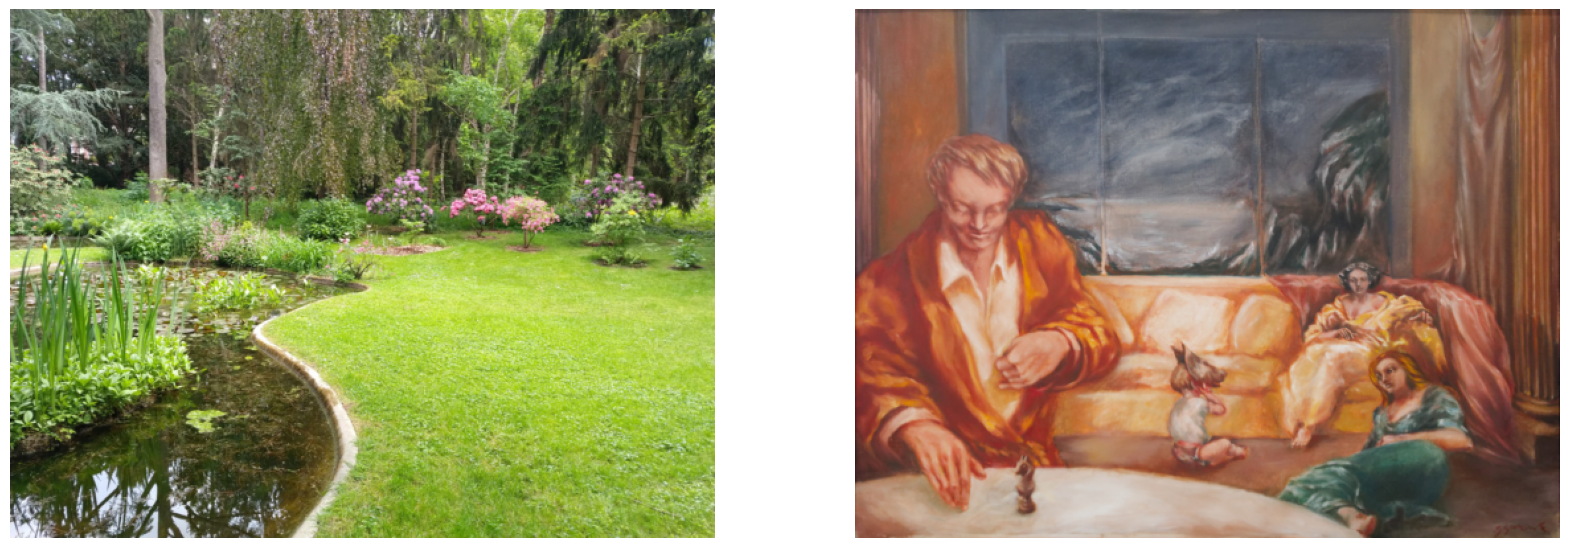

In [9]:
# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

## VGG19 layers

In [10]:
#Print the VGG arquitecture to see the different layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and style features

In [11]:
# get the features from the VGG model

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    for id, layer in model._modules.items():
        x = layer(x)
        if id in layers:
            features[layers[id]] = x
            
        #stop if the last conv layer is reached
        if id == '28':
            break
            
    return features

## Gram matrix

In [12]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [16]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


# Create a target image and prepare it for the optimization
target = content.clone().requires_grad_(True).to(device) #useless?

## Loss functions

In [14]:
# style_weights = [
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.},
    
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 1.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 1.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 1.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 1.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     ]


# style_weights = [
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 1.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 1.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 1.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 1.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     ]

style_weights = {'conv1_1': 0.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6 # beta

## Updating Target Image

#### Testing Different Betas

Style weight:  10
Total loss:  144.53091430664062
LR:  [0.005]
Total loss:  87.71842956542969
LR:  [0.0025]
Total loss:  70.99602508544922
LR:  [0.00125]
Total loss:  64.09622955322266
LR:  [0.000625]
Total loss:  60.80314254760742
LR:  [0.0003125]


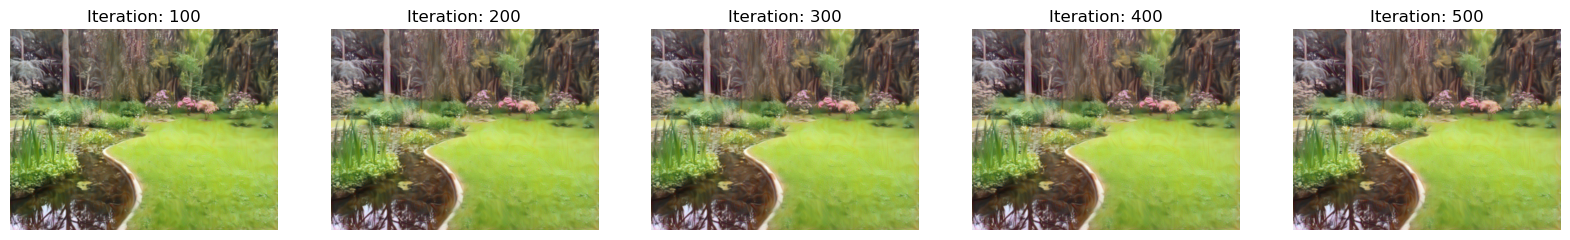

Style weight:  100
Total loss:  623.3610229492188
LR:  [0.01]
Total loss:  372.3946533203125
LR:  [0.005]
Total loss:  301.34356689453125
LR:  [0.0025]
Total loss:  271.299560546875
LR:  [0.00125]
Total loss:  256.7319030761719
LR:  [0.000625]


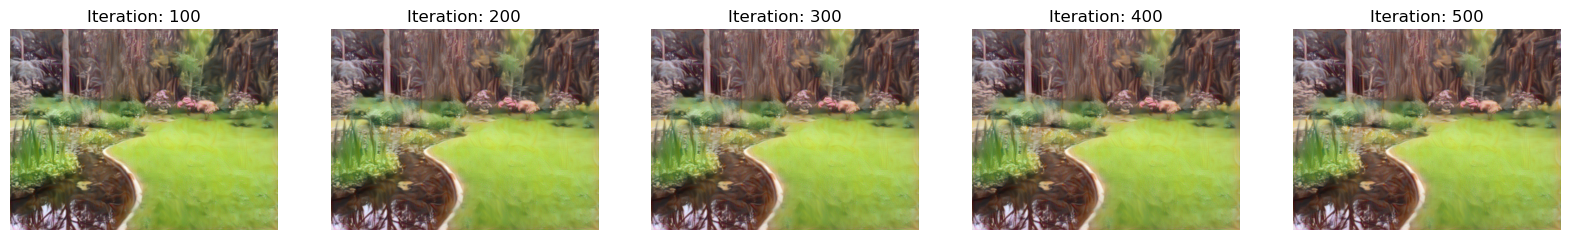

Style weight:  1000
Total loss:  4120.97265625
LR:  [0.015]
Total loss:  2444.822265625
LR:  [0.0075]
Total loss:  1978.9560546875
LR:  [0.00375]
Total loss:  1780.0355224609375
LR:  [0.001875]
Total loss:  1682.9268798828125
LR:  [0.0009375]


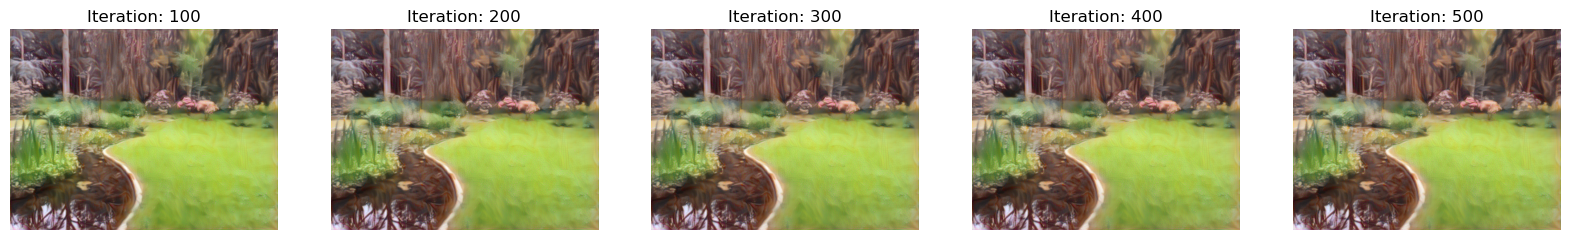

Style weight:  10000
Total loss:  34858.0234375
LR:  [0.02]
Total loss:  18966.126953125
LR:  [0.01]
Total loss:  15330.6708984375
LR:  [0.005]
Total loss:  13818.427734375
LR:  [0.0025]
Total loss:  13081.818359375
LR:  [0.00125]


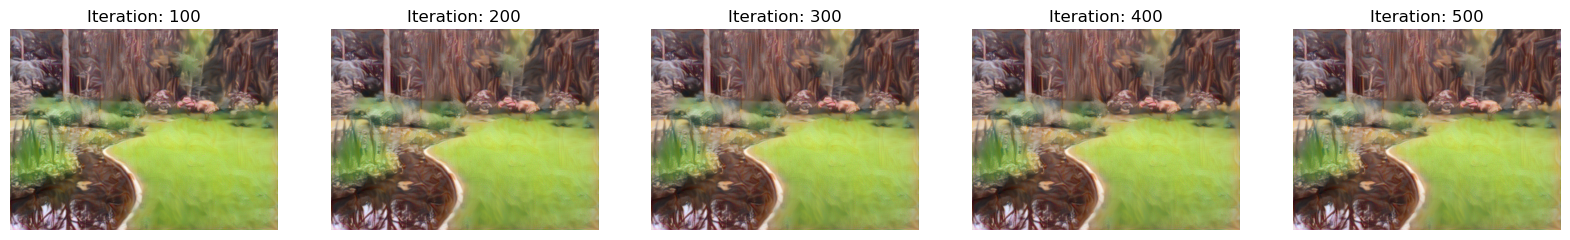

Style weight:  100000
Total loss:  351639.40625
LR:  [0.025]
Total loss:  161201.78125
LR:  [0.0125]
Total loss:  130252.7265625
LR:  [0.00625]
Total loss:  117720.3359375
LR:  [0.003125]
Total loss:  111642.4296875
LR:  [0.0015625]


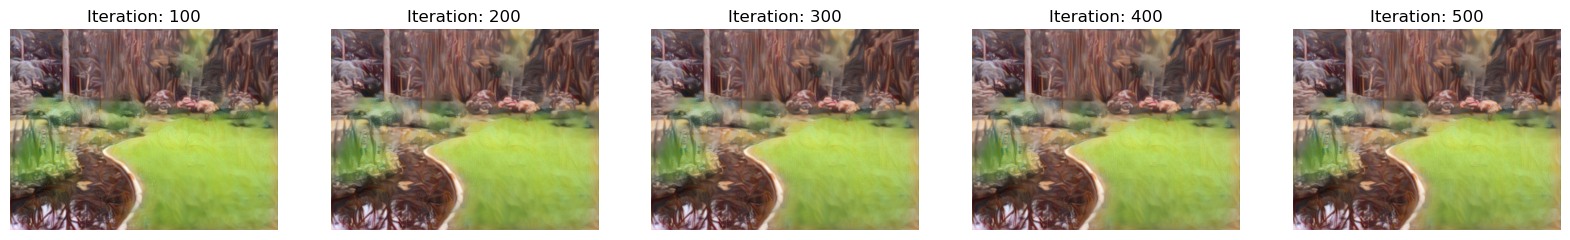

Style weight:  1000000
Total loss:  2487640.75
LR:  [0.03]
Total loss:  1442855.0
LR:  [0.015]
Total loss:  1159988.125
LR:  [0.0075]
Total loss:  1049976.375
LR:  [0.00375]
Total loss:  996511.3125
LR:  [0.001875]


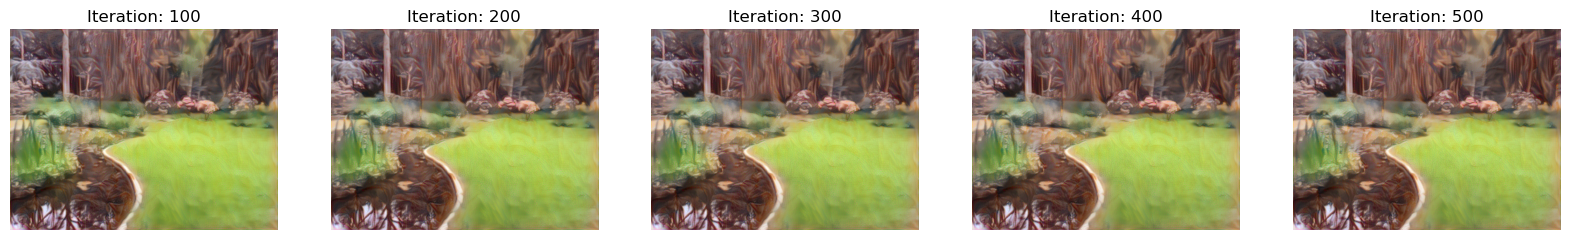

In [18]:
steps = 500
learning_rate = 0.01
step_size = steps/5

images = []

#add a to update the style_weight
for weight in range(1, 7):
    
    style_weight = 10**weight # beta
    print('Style weight: ', style_weight)
    image_target = {"beta": style_weight, "target": [], "iterations": []}
    
    target = content.clone().requires_grad_(True).to(device)
    
    optimizer = optim.Adam([target], lr=learning_rate*(weight))
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) 
    
    for i in range(1, steps+1):

        target_features = get_features(target, vgg)
        
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            _, d, h, w = target_feature.shape
            style_loss += layer_style_loss / (d * h * w) #maybe not needed?
            
        total_loss = content_weight * content_loss + style_weight * style_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        if  i % step_size == 0:
            print('Total loss: ', total_loss.item())
            #print last lr by   current scheduler
            print('LR: ', scheduler.get_last_lr())
            image_target["target"].append(im_convert(target))
            image_target["iterations"].append(i)
            # plt.imshow(im_convert(target))
            # plt.axis('off')
            # plt.show()

        #Plot image result over iterations
        if i == steps:
            fig, axs = plt.subplots(1,int(len(image_target["target"])), figsize=(20, 10))

            for ax, image, iteration in zip(axs.flatten(), image_target["target"], image_target["iterations"]):
                ax.imshow(image)
                ax.set_title(f"Iteration: {iteration}")
                ax.axis('off')
            plt.show()
                
            #fig.suptitle(str(style_w))

            # plt.imshow(im_convert(target))
            # plt.axis('off')
            plt.show()

    #save the final image in an array with the ratio alpha/beta
    images.append({'image': im_convert(target), 'ratio': content_weight/style_weight})


#### Testing Different Style Weights

In [ ]:
# show_every = 100
# #optimizer = optim.Adam([target], lr=0.003)
# steps = 500

# images = []

# #add a for to update the style_weight
# for style_w in style_weights:
    
#     print(style_w)
#     image_target = {"style": style_w, "target": []}
#     target = content.clone().requires_grad_(True).to(device)
#     optimizer = optim.Adam([target], lr=0.003)


#     for i in range(1, steps+1):

#         target_features = get_features(target, vgg)
        
#         content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
#         style_loss = 0
#         for layer in style_w:
#             target_feature = target_features[layer]
#             target_gram = gram_matrix(target_feature)
#             style_gram = style_grams[layer]
#             layer_style_loss = style_w[layer] * torch.mean((target_gram - style_gram)**2)
#             _, d, h, w = target_feature.shape
#             style_loss += layer_style_loss / (d * h * w)
            
#         total_loss = content_weight * content_loss + style_weight * style_loss
        
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
        # if  i % show_every == 0:
        #     print('Total loss: ', total_loss.item())
        #     image_target["target"].append(im_convert(target))
        #     # plt.imshow(im_convert(target))
        #     # plt.axis('off')
        #     # plt.show()

        # #Show the final image
        # if i == steps:
        #     fig, axs = plt.subplots(1,int(len(image_target["target"])), figsize=(20, 10))

        #     for ax, image in zip(axs.flatten(), image_target["target"]):
        #         ax.imshow(image)
        #         ax.axis('off')
                
        #     #fig.suptitle(str(style_w))

        #     # plt.imshow(im_convert(target))
        #     # plt.axis('off')
        #     plt.show()

#     #save the final image in an array with the ratio alpha/beta
#     images.append(im_convert(target))


In [19]:
device

device(type='cuda')

In [20]:
len(images)

6

## Displaying the final image

### Display for different Ratios

In [29]:
print(name_style)

parts = name_style.split("/")
desired_string = parts[-1]
print(desired_string)

garouste - gerard-garouste_1946/garouste_2
garouste_2


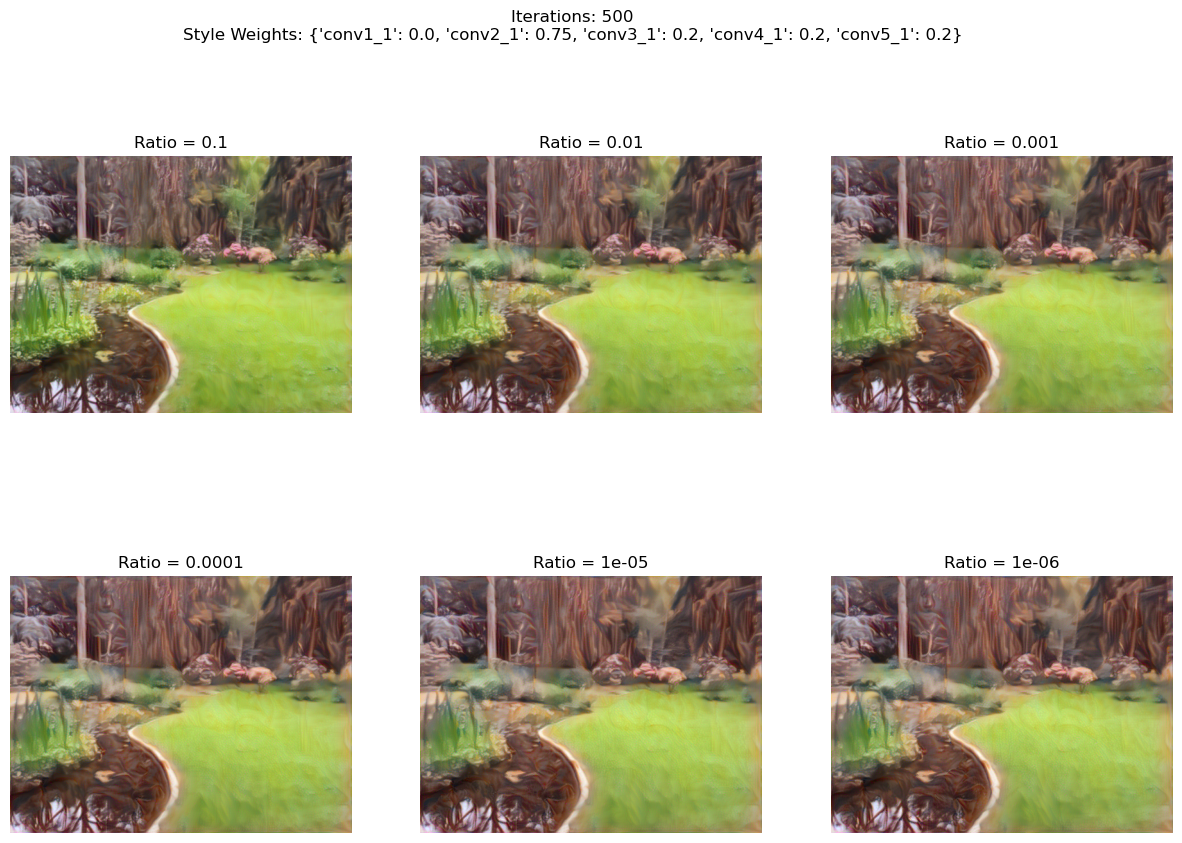

In [39]:
# Create a figure with subplots in a two columns
fig, axs = plt.subplots(2, int(len(images)/2), figsize=(15, 10))

# Add a major title
fig.suptitle('Iterations: {}\nStyle Weights: {}'.format(steps, style_weights))

# Iterate over the flattened array of subplots
for i, (ax, image) in enumerate(zip(axs.flatten(), images)):
    ax.imshow(image['image'])
    ax.axis('off')
    ax.set_title('Ratio = {:}'.format(image['ratio']))

# Save Image
parts = name_style.split("/")
style_img = parts[-1]
name_image = name_content + "_" + style_img  + ".png"

fig.savefig("test/"+name_image)

### Display For different style weights

In [ ]:
# # Create a figure with subplots in a two columns
# fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(10, 20))

# # Iterate over the flattened array of subplots
# for ax, image, styles in zip(axs.flatten(), images, style_weights):
#     ax.imshow(image)
#     ax.axis('off')
#     ax.set_title(str(styles))

# name_image = name_content + "_" + name_style + "_" + str(steps) + "_" + str(learning_rate) +  "style.png"

# fig.savefig("test/"+name_image)


(-0.5, 532.5, 399.5, -0.5)

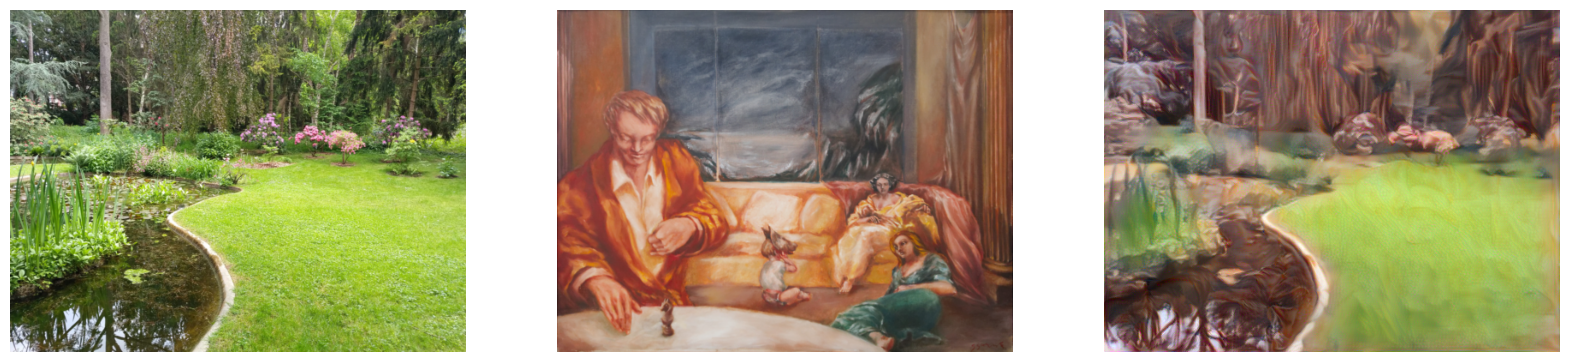

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

# Evaluation

In [ ]:
import torch
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np

# Load Inception V3 model pre-trained on ImageNet
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()  # Use the model in evaluation mode
if torch.cuda.is_available():
    inception_model.cuda()

def get_inception_features(images, model, batch_size=32):
    """ Calculate the Inception model features for a set of images. """
    model.eval()
    all_features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = torch.stack(images[i:i + batch_size]).to('cuda')
            features = model(batch).detach().cpu().numpy()
            all_features.append(features)
    all_features = np.concatenate(all_features, axis=0)
    return all_features

def calculate_inception_score(features, eps=1e-16):
    """ Calculate the Inception Score given Inception model features. """
    softmax = np.exp(features) / np.sum(np.exp(features), axis=1, keepdims=True)
    marginal_mean = np.mean(softmax, axis=0)
    kl_div = softmax * (np.log(softmax + eps) - np.log(marginal_mean + eps))
    kl_mean = np.mean(np.sum(kl_div, axis=1))
    return np.exp(kl_mean)

def calculate_fid(real_features, fake_features):
    """ Calculate the Fréchet Inception Distance between real and fake features. """
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu_real - mu_fake) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
